In [1]:
import leafmap
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from samgeo import split_raster, merge_rasters
from samgeo.text_sam import LangSAM
from utils import plot_overlay, create_empty_mask, increase_contrast, increase_saturation

In [5]:
TRAIN_PATH = '../data/Potsdam/Train'
PREDICTED_PATH = '../data/Potsdam/Predicted'

train_ids = next(os.walk(TRAIN_PATH))[1]
print (train_ids)

['32688_5332_label.png', '32688_5332.tif', '32690_5335.tif', '32692_5347.tif', '32692_5347_label.png', '32691_5334.tif', '32692_5335.tif']


In [ ]:
# %env CUDA_VISIBLE_DEVICES="" # to run on CPU

In [6]:
# SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_l_0b3195.pth"
# MODEL_TYPE = "vit_l"
SAM_CHECKPOINT = "../segment-anything/checkpoints/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
sam = LangSAM(model_type=MODEL_TYPE, checkpoint=SAM_CHECKPOINT)

final text_encoder_type: bert-base-uncased


### Predict full image

In [4]:
box_threshold = 0.3
text_threshold = 0.5
text_prompt = "tree . lawn . gras"
contrast_params = (1.5, -50)
saturation_factor = 1.5

SUBFOLDER = "samgeo_v3"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))
    f.write("contrast: alpha={}, beta={}\n".format(contrast_params[0], contrast_params[0]))
    f.write("saturation factor: {}\n".format(saturation_factor))


for id in train_ids:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    # Construct paths for image and mask
    img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
    
    # store modified image in tmp folder
    tmp_image = "tmp/image.png"
    increase_contrast(img_path, output=tmp_image, alpha=contrast_params[0], beta=contrast_params[1])
    increase_saturation(tmp_image, output=tmp_image, factor=saturation_factor)
    img_path = tmp_image
    
    
    text_prompt = "tree . forest . gras"
    mask_path = os.path.join(RESULT_PATH, file_prefix + '_predicted.tif')
    
    res = sam.predict(img_path, text_prompt, 
                box_threshold=box_threshold, 
                text_threshold=text_threshold, 
                output=mask_path,
                return_results=True
                )
    # create empty mask because samgeo does not create empty masks
    if res is None:
        
        create_empty_mask(img_path, mask_path)
        
   
print(f"Done! Results saved to: {RESULT_PATH}") 

No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.


2023-12-11 18:42:13.077766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 18:42:13.077801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 18:42:13.078683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 18:42:13.084645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 18:42:13.825965: W tensorflow/compiler/tf2

No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objects found in the image.
No objec

### Prediction in batches

In [ ]:
box_threshold = 0.25
text_threshold = 0.5
text_prompt = "tree . lawn . gras"
tile_size = 256
overlap = 64

SUBFOLDER = "batches_1"

RESULT_PATH = os.path.join(PREDICTED_PATH, SUBFOLDER)

# create prediction directory
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)
    
# create info file with parameters
with open(os.path.join(RESULT_PATH, "info.txt"), "w") as f:
    f.write("box_threshold: {}\n".format(box_threshold))
    f.write("text_threshold: {}\n".format(text_threshold))
    f.write("text_prompt: {}\n".format(text_prompt))
    f.write("model_type: {}\n".format(MODEL_TYPE))
    f.write("tile_size: {}\n".format(tile_size))
    f.write("overlap: {}\n".format(overlap))
    
# tmp folder for batch segmentation
WORK_DIR = "tmp"
tiles_dir = f"{WORK_DIR}/tiles"
mask_dir = f"{WORK_DIR}/masks"


for id in train_ids:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    # Construct paths for image and mask
    img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
    
    # empty tmp/masks and tmp/tiles directories
    os.system(f"rm -rf {tiles_dir}/*")
    os.system(f"rm -rf {mask_dir}/*")
    
    # split images into tiles
    split_raster(img_path, out_dir=tiles_dir, tile_size=tile_size, overlap=overlap)
    
    # sam.batch_predict written on my own to fix not creating empty masks
    if isinstance(tiles_dir, str):
        all_files = os.listdir(tiles_dir)
        images = [os.path.join(tiles_dir, file) for file in all_files if file.endswith(".tif")]
        images.sort()

    for i, image in enumerate(images):
        basename = os.path.splitext(os.path.basename(image))[0]

        output = os.path.join(mask_dir, f"{basename}_mask.tif")
        res = sam.predict(
            image,
            text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            output=output,
            return_results=True
        )
        
        # create empty mask because samgeo does not create empty masks
        if res is None:
            create_empty_mask(image, output)
        

    # merge tiles into one mask
    mask_path = os.path.join(RESULT_PATH, file_prefix + '_predicted.tif')
    merge_rasters(mask_dir, mask_path)
    
    

print(f"Done! Results saved to: {RESULT_PATH}") 

## Evaluation

In [5]:
TRAIN_PATH = '../data/Potsdam/Train'
PREDICTED_PATH = '../data/Potsdam/Predicted/samgeo_v3'

train_ids = next(os.walk(TRAIN_PATH))[1]

../data/Potsdam/Train/t7_7_0_9/top_potsdam_7_7_0_9_RGB.tif ../data/Potsdam/Train/t7_7_0_9/top_potsdam_7_7_0_9_label.tif ../data/Potsdam/Predicted/samgeo_v3/top_potsdam_7_7_0_9_predicted.tif


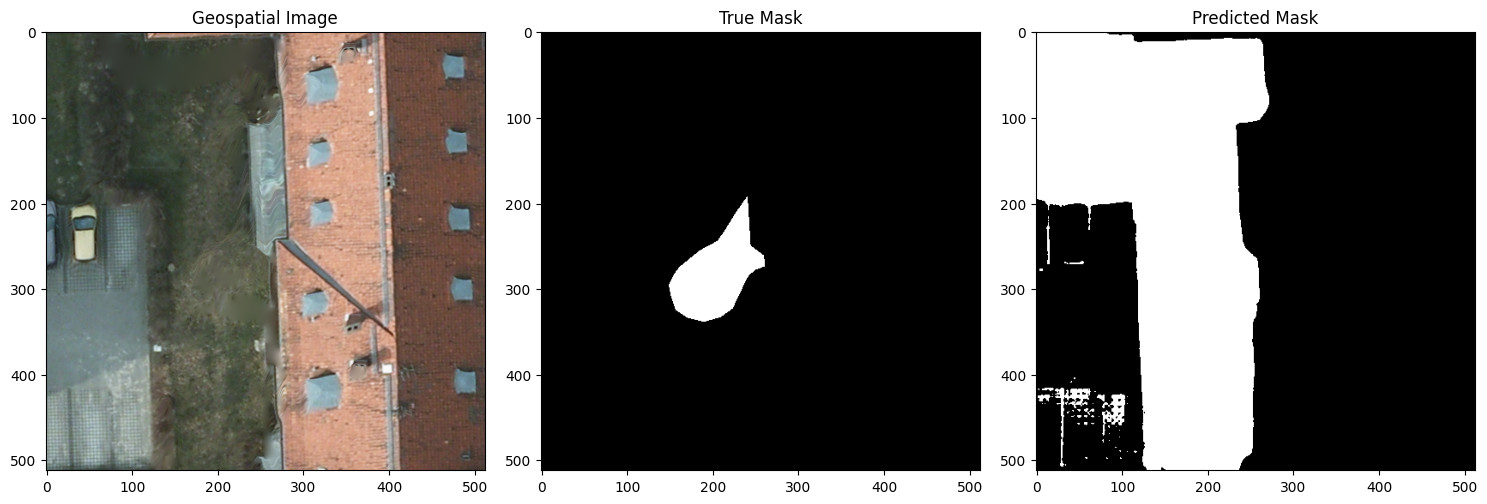

In [6]:
# show one image
id = train_ids[19]
file_prefix = 'top_potsdam_' + id.replace("t","")
img_path = os.path.join(TRAIN_PATH, id, file_prefix + '_RGB.tif')
mask_path = os.path.join(TRAIN_PATH, id, file_prefix + '_label.tif')
predicted_path = os.path.join(PREDICTED_PATH, file_prefix + '_predicted.tif')
print(img_path, mask_path, predicted_path)

# plot 3 images first actual then label and predicted
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path)
predicted = cv2.imread(predicted_path)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Geospatial Image')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('True Mask')
plt.subplot(1, 3, 3)
plt.imshow(predicted)
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()

In [2]:
import sys
sys.path.append('../mask-evaluation')
from main import print_metrics, evaluate_mask
from collections import Counter

In [9]:

data = []

for id in train_ids:
    # Construct paths for image and mask
    file_prefix = 'top_potsdam_' + id.replace("t","")
    
    text_prompt = "tree, gras"
    mask_path = os.path.join(TRAIN_PATH, id, file_prefix + '_label.tif')
    predicted_path = os.path.join(PREDICTED_PATH, file_prefix + '_predicted.tif')
    data.append((predicted_path, mask_path))
    

def evaluate_mask_file(base_mask_path: str, predicted_mask_path: str) -> Counter:
    expected = cv2.imread(base_mask_path)
    actual = cv2.imread(predicted_mask_path)
    return evaluate_mask(expected, actual)


res = sum([evaluate_mask_file(base, actual) for base, actual in data], Counter())

print_metrics(res)


Results: 
   accuracy: 75.855 %
         f1:  0.477
     recall:  0.356 (or sensitivity)
  precision:  0.724
specificity:  0.939

TPR: 0.356 | FNR: 0.644
TNR: 0.939 | FPR: 0.061
PPV: 0.724 | FDR: 0.276
NPV: 0.765 | FOR: 0.235
